In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

acc = pd.read_csv('all_accelerometer_data_pids_13.csv')
acc

,time,pid,x,y,z
0,0,JB3156,0.000000,0.000000,0.000000
1,0,CC6740,0.000000,0.000000,0.000000
2,1493733882409,SA0297,0.075800,0.027300,-0.010200
3,1493733882455,SA0297,-0.035900,0.079400,0.003700
4,1493733882500,SA0297,-0.242700,-0.086100,-0.016300
...,...,...,...,...,...
14057562,1493829248196,CC6740,-0.133956,0.124726,-0.010736
14057563,1493829248220,CC6740,-0.100764,0.180872,0.046449
14057564,1493829248245,CC6740,-0.131853,0.195934,0.181088
14057565,1493829248270,CC6740,-0.149704,0.194482,0.202393


In [15]:
acc['datetime'] = pd.to_datetime(acc['time'], unit='ms')

In [2]:
import os

folder = 'clean_tac/'

# get all files in the folder
files = os.listdir(folder)

# get all the pids
pids = [str(file.split('_clean_TAC.')[0]) for file in files]

# get all the TAC readings for each person in a dictionary
tac_dict = {pid: pd.read_csv(folder + str(pid) + '_clean_TAC.csv') for pid in pids}


In [3]:
# get the TAC readings for a specific person
def get_tac_data(pid):
    return tac_dict[pid]

# concatenate all the TAC readings into one dataframe, with a pid column
def get_tac_full_data():
    tac_full_data = pd.DataFrame()
    for pid in pids:
        tac_data = get_tac_data(pid)
        tac_data = tac_data.assign(pid=[pid]*len(tac_data))
        tac_full_data = pd.concat([tac_full_data,tac_data])
    return tac_full_data

In [5]:
tac = get_tac_full_data()
tac

,timestamp,TAC_Reading,pid
0,1493718714,-0.000482,BK7610
1,1493720697,0.001573,BK7610
2,1493721027,0.002144,BK7610
3,1493721357,0.000877,BK7610
4,1493721686,-0.001145,BK7610
...,...,...,...
49,1493797974,0.029049,SF3079
50,1493799820,0.016286,SF3079
51,1493801652,0.004243,SF3079
52,1493803481,-0.001995,SF3079


In [23]:
# convert the unix timestamp column to a datetime column without removing the original column
tac['datetime'] = pd.to_datetime(tac['timestamp'], unit='s')
tac

,timestamp,TAC_Reading,pid,datetime
0,1493718714,-0.000482,BK7610,2017-05-02 09:51:54
1,1493720697,0.001573,BK7610,2017-05-02 10:24:57
2,1493721027,0.002144,BK7610,2017-05-02 10:30:27
3,1493721357,0.000877,BK7610,2017-05-02 10:35:57
4,1493721686,-0.001145,BK7610,2017-05-02 10:41:26
...,...,...,...,...
49,1493797974,0.029049,SF3079,2017-05-03 07:52:54
50,1493799820,0.016286,SF3079,2017-05-03 08:23:40
51,1493801652,0.004243,SF3079,2017-05-03 08:54:12
52,1493803481,-0.001995,SF3079,2017-05-03 09:24:41


In [38]:
(1493801652 - 1493803481) / 60

-30.483333333333334

In [34]:
import plotly.graph_objects as go

fig = go.Figure()

for person in tac['pid'].unique():
    filtered_tac = tac[tac['pid'] == person]
    fig.add_trace(go.Scatter(x=filtered_tac['datetime'], y=filtered_tac['TAC_Reading'], name=person))

# Create a button to toggle between each person
buttons = []
for person in tac['pid'].unique():
    button = dict(label=person,
                  method='update',
                  args=[{'visible': [person == visible for visible in tac['pid'].unique()]}])
    buttons.append(button)

fig.update_layout(updatemenus=[dict(buttons=buttons)], height=700)

# Show the figure
fig.show()

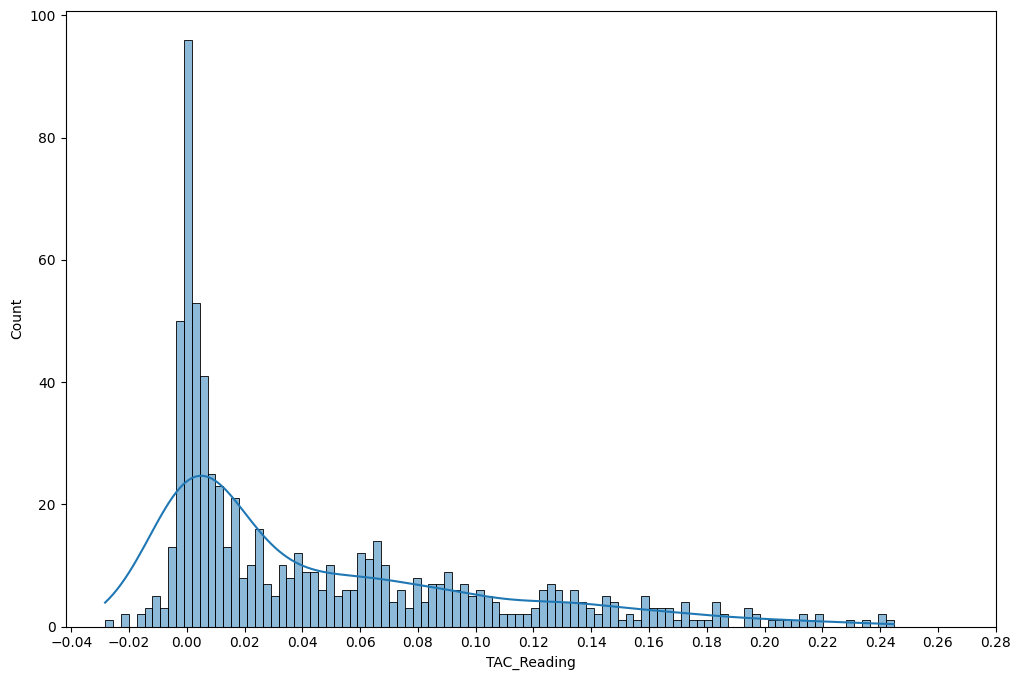

In [77]:
plt.figure(figsize=(12, 8))
_ = sns.histplot(data=tac, x='TAC_Reading', kde=True, bins=100)
_ = plt.xticks(np.arange(-0.04, 0.3, 0.02))

In [79]:
tac

,timestamp,TAC_Reading,pid,datetime
0,1493718714,-0.000482,BK7610,2017-05-02 09:51:54
1,1493720697,0.001573,BK7610,2017-05-02 10:24:57
2,1493721027,0.002144,BK7610,2017-05-02 10:30:27
3,1493721357,0.000877,BK7610,2017-05-02 10:35:57
4,1493721686,-0.001145,BK7610,2017-05-02 10:41:26
...,...,...,...,...
49,1493797974,0.029049,SF3079,2017-05-03 07:52:54
50,1493799820,0.016286,SF3079,2017-05-03 08:23:40
51,1493801652,0.004243,SF3079,2017-05-03 08:54:12
52,1493803481,-0.001995,SF3079,2017-05-03 09:24:41


In [89]:
k_tac = tac[tac.pid == 'BK7610']

In [86]:
# interpolate the TAC_Reading (which is collected every 30 minutes) to every minute
k_tac = k_tac.set_index('datetime')
k_tac = k_tac.resample('1min').mean()
k_tac = k_tac.interpolate(method='time')
k_tac = k_tac.reset_index()


In [88]:
k_tac

,datetime,timestamp,TAC_Reading
0,2017-05-02 09:51:00,1.493719e+09,-0.000482
1,2017-05-02 09:52:00,1.493719e+09,-0.000420
2,2017-05-02 09:53:00,1.493719e+09,-0.000358
3,2017-05-02 09:54:00,1.493719e+09,-0.000296
4,2017-05-02 09:55:00,1.493719e+09,-0.000233
...,...,...,...
1483,2017-05-03 10:34:00,1.493808e+09,-0.002444
1484,2017-05-03 10:35:00,1.493808e+09,-0.002516
1485,2017-05-03 10:36:00,1.493808e+09,-0.002588
1486,2017-05-03 10:37:00,1.493808e+09,-0.002660


In [87]:
k_tac

,datetime,timestamp,TAC_Reading
0,2017-05-02 09:51:00,1.493719e+09,-0.000482
1,2017-05-02 09:52:00,1.493719e+09,-0.000420
2,2017-05-02 09:53:00,1.493719e+09,-0.000358
3,2017-05-02 09:54:00,1.493719e+09,-0.000296
4,2017-05-02 09:55:00,1.493719e+09,-0.000233
...,...,...,...
1483,2017-05-03 10:34:00,1.493808e+09,-0.002444
1484,2017-05-03 10:35:00,1.493808e+09,-0.002516
1485,2017-05-03 10:36:00,1.493808e+09,-0.002588
1486,2017-05-03 10:37:00,1.493808e+09,-0.002660


In [83]:
k_tac[['datetime', 'TAC_Reading']].interpolate(method='time', inplace=True)

ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got time